# Rebound Zone - ShotQuality: NCAA Player Location Data & Rebounds

This notebook aims to predict probability of offensive rebounding in basketball based on the locations of at when a shot is released. It adapts existing metrics in other sports (such as soccer and hockey), to determine how much control a player has over each area of the court, given the locations of all the players. Combining these two statistics gives the probability for how likely a player or team is to secure a [rebound](https://youtu.be/atr60tR7Emo) at a any spot on the court. 

## Contents
1. [Imports](#section1)
2. [Definitions](#section2)
3. [Testing and Optimization](#section3)



___

<a id='section1'></a>

## <a id='#section1'>1. Imports and Processing</a>

This notebook requires the following Python libraries, which we import here:

In [718]:
# Sampling shot attempts for optimizing parameters
from random import shuffle

# Math and data operations
import numpy as np
import pandas as pd

# Data visualization
from matplotlib import pyplot as plt
import matplotlib.colors as clr
import seaborn as sns

# Progress bar for loops
from tqdm.auto import tqdm

# Calculating log loss for parameter optimization
from sklearn.metrics import log_loss

Then we import the competition data:

In [719]:
train_locs = pd.read_csv('train_locs.csv')
train_pbp  = pd.read_csv('train_pbp.csv')

test_locs = pd.read_csv('test_locs.csv')
test_pbp  = pd.read_csv('test_pbp.csv')

train_locs.head(10)

,id,court_x,court_y,annotation_code
0,44959,72.807686,37.409669,d1
1,44959,79.080643,31.477796,d2
2,44959,69.956321,24.467300,d3
3,44959,75.468933,13.861763,d4
4,44959,84.973496,19.254422,d5
5,44959,69.994331,39.674616,s
6,44959,82.692421,32.736070,t1
7,44959,81.741959,17.097372,t2
8,44959,71.667114,12.603488,t3
9,44959,58.550842,12.962986,t4


### Processing

While a shooting event can be on either side of the court, we only want to work in a half court setting. Therefore we reflect all players on the right half of the court to be on the left:

In [720]:
def mirror(item):
    """ Reflect the x-coordinates of rebounding events to all be in one half of the court

    Args:
        item: float
            The x-coordinate
    
    Returns:
        float
            The x-coordinate reflected to be a value less than 47 (half court)
    """
    if item > 47:
        item *= -1
        item += 94
    return item

train_locs['court_x'] = train_locs.court_x.apply(mirror)
test_locs['court_x'] = test_locs.court_x.apply(mirror)

Then, to more easily work with the x- and y-coordinates for the players, we add an additional column to the location tables with (x, y) coordinate pairs:

In [721]:
train_locs['coords'] = list(zip(train_locs.court_x,train_locs.court_y))
test_locs['coords'] = list(zip(test_locs.court_x,test_locs.court_y))

train_locs.head()

,id,court_x,court_y,annotation_code,coords
0,44959,21.192314,37.409669,d1,"(21.192313999999996, 37.4096687)"
1,44959,14.919357,31.477796,d2,"(14.919357450000007, 31.47779611)"
2,44959,24.043679,24.467300,d3,"(24.043678580000005, 24.46729953)"
3,44959,18.531067,13.861763,d4,"(18.531066600000003, 13.86176256)"
4,44959,9.026504,19.254422,d5,"(9.026504220000007, 19.25442219)"


Lastly, to make sure that the training data is representative of the test data, we look as the distribution of shot attempts for both sets and note the similarities.

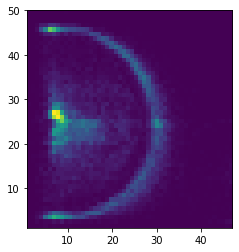

In [722]:
# Training
H, xedges, yedges = np.histogram2d(train_locs.loc[train_locs.annotation_code=='s'].court_x,train_locs.loc[train_locs.annotation_code=='s'].court_y,bins=50)
H=H.T

plt.imshow(H, interpolation='nearest', origin='lower',

        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]]);


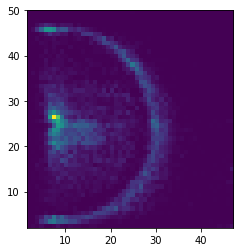

In [723]:
# Test
H, xedges, yedges = np.histogram2d(test_locs.loc[test_locs.annotation_code=='s'].court_x,test_locs.loc[test_locs.annotation_code=='s'].court_y,bins=50)
H=H.T

plt.imshow(H, interpolation='nearest', origin='lower',

        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]]);


___

<a id='section1'></a>

## <a id='#section2'>2. Definitions and Initial Analysis</a>

Much of the modeling in this workbook is based upon the research in [Pass Evaluation in Women’s Olympic Hockey](https://arxiv.org/pdf/2205.13678.pdf), which uses a metric called rink control to measure how much a team controls a certain region of the ice. We adapt this metric for use in basketball for the same purpose on the court.

First, we define constants to be used throughout the project:

In [724]:
# Number of bins to be used for calculations and plotting
num_bins = 30

# Half-court size constraints
max_x, max_y = 47, 50

# Constant used in court control formula
beta = 2.5

Next, we define multiple custom functions that will be used to process and analyze the data. 

### Court Control

The `control` function is our adaptation of the rink control metric. It takes into account all players' locations, and returns the relative control for the teams on each location in an array representing the half-court.

In [725]:
def control(playerCoords, beta=2.5, def_scale=1):
    """ Calculate the realtive team control of each area in a grid, given the position of each player

    Args:
        playerCoords: list 
            list of of (x, y) ordered pairs, respresenting players' locations on the court
        beta: float
            a parameter to measure the importance of being the the closest player to a location; where β = 0 yields a control equal to the
            proportion of offensive team players on the ice and β = ∞ yields a control  of 1 if the closest player belongs to the offensive 
            team and 0 otherwise
        def_scale: float
            a parameter to change the inherent rebounding ability of the defense relative to the offense; values lower than 1 increase
            modeled rebounding ability
    
    Returns:
        numpy.array 
            array where each entry represents the relative control of that location on the court, with -1 meaning complete defensive 
            control and 1 meaning complete offensive control
    """
    
    distances = np.zeros(x.shape)
    sum = np.zeros(x.shape)

    for i, node in enumerate(playerCoords):
        distance = np.sqrt((x-node[0])**2 + (y-node[1])**2)
        
        quantity = distance
        if i<=4: # if on defensive team
            quantity = quantity**def_scale # scale defensive rebounding ability

        sum += (quantity)**(-beta)
        if i > 4: # offense
            distances = distances + (quantity)**(-beta)
        elif i <= 4: # defense
            distances = distances - (quantity)**(-beta)
    return (distances/sum)


Let us illustrate the control concept with an example.

Control over an area on the court by a given team is strongest around each of their players, and having multiple players in an area extends that control further. This connects to real-world situations, where some teammates would box out to further control space, while other players would be free to grab the rebound. Meanwhile, control is relatively even in areas between players of different teams, as well as at areas far away from any players. This makes sense intutively, as contested rebounds and long rebounds that bounce and roll are often considered 'fifty-fifty balls'.

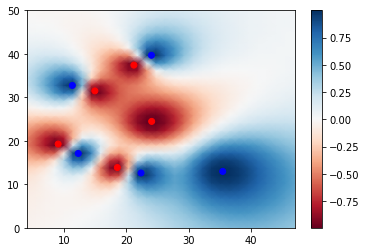

In [726]:
X = np.linspace(4,max_x,num_bins)
Y = np.linspace(0,max_y,num_bins)
x, y = np.meshgrid(X,Y)

sample_event = train_locs.iloc[:10]
ctrl = control(sample_event.coords.to_list())

sample_x = [c[0] for c in sample_event.coords]
sample_y = [c[1] for c in sample_event.coords]
colors = ['r' if i<=4 else 'b' for i in range(10)]

plt.pcolormesh(x,y,ctrl,shading='gouraud',cmap='RdBu')
plt.colorbar()
plt.scatter(sample_x,sample_y,color=colors);

### Rebound Distributions

Rebounds are not [evenly distributed](https://www.shobix.co.jp/hpm/tempfiles/journal/2009/08J058.pdf) across the court. Therefore, we cannot only use the court control to predict the chance of getting an offensive rebound. 

The `reboundDist` function is our solution to this, and it is inspired by the scoring probability metric from the previously mentioned hockey research. Instead of scoring probability, this function models the relative chances that a rebound will go to different areas on the court. Since the distribution of rebounds is dependent on the [angle a shot is taken from](https://grantland.com/features/how-rebounds-work/), this function rotates the distribution based on the shooter's location.

In [727]:

def reboundDist(angle, x_scale=600, y_scale=300):
    """ Calculate the realtive distribution of rebounds in a grid, given the angle between the shooter and the basket

    Args:
        angle: float 
            angle between the shooter and the basket, in radians, with 0 being facing the basket from the top of the key
        x_scale: float
            a parameter to scale the distribution of rebounds from sideline to sideline, with larger values increasing the relative frequency for further distances
        y_scale: float
            a parameter to scale the distribution of rebounds from the baseline to half-court, with larger values increasing the relative frequency for further distances

    
    Returns:
        numpy.array 
            array where each entry represents the relative probability that a rebound will land in that location of the court
    """

    rota_x = (x-4)*np.cos(-angle) - (y-25)*np.sin(-angle)
    rota_y = (x-4)*np.sin(-angle) + (y-25)*np.cos(-angle)
    initial_dist = ((rota_x)**2/x_scale+(rota_y)**2/y_scale)
    dist = np.exp(-initial_dist)

    return dist/np.sum(dist)

A simple visualization of this function is shown below:

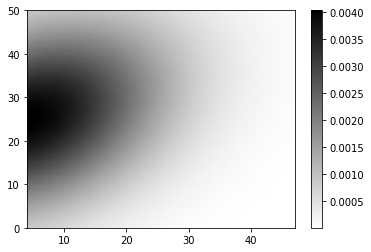

In [728]:
plt.pcolormesh(x,y,reboundDist(np.deg2rad(45)),shading='gouraud',cmap='binary')
plt.colorbar();

## Offensive Rebound Probability

Lastly, we combine the court control and rebound distribution into a final function that will return the predicted probability of an offensive rebound, given the locations of the players on the court.

The `offReboundProb` function calculates the court control and scales it from 0 to 1. Then, it calculates the angle between the shooter and the basket (with 0 degrees being facing the basket from the top of the key), as well as the distance the shooter is to the basket. Since the [distance a shot is taken from](https://fansided.com/2020/01/28/nylon-calculus-nba-rebound-tracking/) affects offensive rebounding probabilities, this function adjust the scale of the rebound distribution based on shot distance. Finally, the function multiplies the control by the rebound distribution and sums the entries of the resulting array to return the predicted probability. 

In [729]:
def offReboundProb(playerCoords, beta=2.5, x_scale=200, y_scale=200, def_scale=1, dist_scale=10):
    """ Calculate the probability that the offensive team will get the rebound, given the location of the players and shooter

    Args:
        playerCoords: list 
            list of of (x, y) ordered pairs, respresenting players' locations on the court
        beta: float
            a parameter to measure the importance of being the the closest player to a location; where β = 0 yields a control equal to the
            proportion of offensive team players on the ice and β = ∞ yields a control  of 1 if the closest player belongs to the offensive 
            team and 0 otherwise
        x_scale: float
            a parameter to scale the distribution of rebounds from sideline to sideline, with larger values increasing the relative frequency for further distances
        y_scale: float
            a parameter to scale the distribution of rebounds from the baseline to half-court, with larger values increasing the relative frequency for further distances
        def_scale: float
            a parameter to change the inherent rebounding ability of the defense relative to the offense; values lower than 1 increase
            modeled rebounding ability
        dist_scale: float
            a parameter to change the relative rebound distribution based on the location of the shooter
    
    Returns:
        float
            probability of an offensive rebound
    """
    
    prob = (control(playerCoords, beta, def_scale)+1)/2
    angle = np.arctan2((playerCoords[5][1]-25), (playerCoords[5][0]-4))
    shooter_dist = np.sqrt((playerCoords[5][1]-25)**2 + (playerCoords[5][0]-4)**2)
    
    return np.sum(reboundDist(angle, x_scale, y_scale*shooter_dist/dist_scale)*prob)

So, working with the example used with the control function, and the default parameters, the chance of an offensive rebound is:

In [730]:
offReboundProb(sample_event.coords.to_list())

0.4671894741717749

___

<a id='section3'></a>

## <a id='#section3'>3. Testing and Optimization</a>

So far, many of the parameters we have been using in our functions have been estimations using prior knowledge of rebounding and basketball. We aim to verify and/or improve these parameters to reduce the log loss of our predictions. 

We will be keeping the value of $β = 2.5$, as that has been standard for applications in multiple sports.

### Rebound Distribution Scaling

We aim to find the optimal parameters describing the decay in rebounding probability with respect to the distance from the goal (i.e. the `x_scale` and `y_scale` parameters of the `reboundDist` function). This is done through an iterative process in which for each combination of x and y scale parameters, we sample 1000 shot events from the training data, predict the offensive rebound probabilities for those shots, and then calculate the log loss of our predictions. We use values from 50 to 500 for training the scaling parameters, as this is a realistic range of values based upon our knowledge of basktball and the rebound distribution formula.

In [731]:
coords = train_locs.coords.to_list()
logloss_outer = []

for y_param in tqdm(np.linspace(50,500,10)):
    logloss_inner = []
    for x_param in tqdm(np.linspace(50,500,10), leave=False):
        sample = np.random.permutation(len(train_pbp))[:1000]

        train_probs = []
        for game in sample:
            train_probs.append(offReboundProb(coords[10*game: 10*(game + 1)], 2.5, x_param, y_param))
        logloss_inner.append(log_loss(train_pbp.iloc[sample,1],train_probs))
    logloss_outer.append(logloss_inner)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Visualizing the log loss with a heatmap, we can see that as the values of both parameters increase, so does the log loss. However, this increase is greater with the y parameter than it is with the x. With that being said, we will be using 200 for the x-scale and 50 for the y-scale.

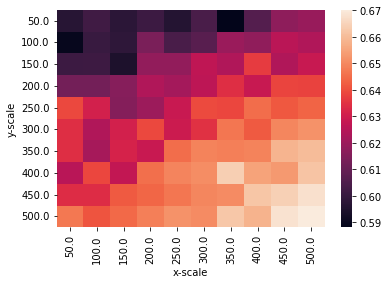

In [732]:
ax = sns.heatmap(logloss_outer,xticklabels=np.linspace(50,500,10),yticklabels=np.linspace(50,500,10))
ax.set(xlabel='x-scale', ylabel='y-scale');

### Defense and Distance Scaling

Next, we optimize the for scaling the defense's rebounding ability and for scaling the size of the rebound distribution based on the distance of the shooter from the basket (i.e. the `def_scale` and `dist_scale` parameters of the `offReboundProb` function). We use the smae iterative process as before, but with unique ranges for the defense and distance parameters. The range for the defense parameter should be a value close to 1 becuase we only want minimal scaling, and it will likely be less than 1 based on our understanding that the defense has an advantage when it comes to rebounding. The range for the distance parameter testing is based upon the typical range of shot attempts in basketball.

In [733]:
logloss_outer2 = []

for dist in tqdm(np.linspace(1,20,10)):
    logloss_inner2 = []
    for defen in tqdm(np.linspace(.5,1.2,10), leave=False):
        sample = np.random.permutation(len(train_pbp))[:1000]

        train_probs = []
        for game in sample:
            train_probs.append(offReboundProb(coords[10*game: 10*(game + 1)], 2.5, 200, 50, defen, dist))
        
        logloss_inner2.append(log_loss(train_pbp.iloc[sample,1],train_probs))
    logloss_outer2.append(logloss_inner2)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Visualizing the log loss with a heatmap, we can see that the optimal values for the defense scale are in the middle, validating our range selection. There is not as clear a pattern for the distance scale, but with our selected value for the defense scale, the ideal distance parameter appears to be in the lower middle range. With that being said, we will be using 0.9 for the defense scale and 14 for the distance scale.

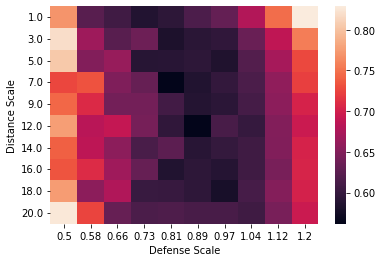

In [734]:
ax = sns.heatmap(logloss_outer2,xticklabels=np.round(np.linspace(.5,1.2,10),2),yticklabels=np.round(np.linspace(1,20,10)))
ax.set(xlabel='Defense Scale', ylabel='Distance Scale');

___

<a id='section3'></a>

## <a id='#section3'>4. Predictions</a>

Finally, we will calculate our predictions on the test data and prepare it for submission.

In [735]:
test_coords = test_locs.coords.to_list()
probs_test = []

for game in tqdm(range(len(test_pbp.index))):
    probs_test.append(offReboundProb(test_coords[10*game: 10*(game + 1)],beta=2.5,x_scale=200,y_scale=50,def_scale=0.9,dist_scale=14))

  0%|          | 0/13202 [00:00<?, ?it/s]

___
Log loss for training data

In [736]:
probs = []

for game in tqdm(range(len(train_pbp.index))):
    probs.append(offReboundProb(coords[10*game: 10*(game + 1)],beta=2.5,x_scale=200,y_scale=50,def_scale=0.9,dist_scale=14))

  0%|          | 0/30805 [00:00<?, ?it/s]

In [737]:
log_loss(train_pbp.is_oreb,probs)

0.584869929489473

___

In [738]:
sub = pd.DataFrame(test_pbp.id)
sub['pred'] = probs_test
sub = sub.sort_index()
sub

,id,pred
0,2790-2,0.267345
1,4712-4,0.184448
2,2094-2,0.286864
3,4956-9,0.145611
4,2135-5,0.284619
...,...,...
13197,4525-7,0.232074
13198,5006-9,0.296029
13199,4737-6,0.355004
13200,390-3,0.193992


In [739]:
sub.to_csv('submission.csv', index=False)